# Introducción del Proyecto

Este proyecto aborda el análisis y priorización de hipótesis para optimizar los ingresos de una tienda online, así como la evaluación de un experimento A/B.

En la primera fase, se dispone de nueve hipótesis con información sobre alcance (Reach), impacto (Impact), confianza (Confidence) y esfuerzo (Effort). El objetivo es priorizarlas utilizando los frameworks ICE y RICE, comparando los resultados y explicando las diferencias entre ambos enfoques.

En la segunda fase, se analizan los resultados de un test A/B que incluye datos de pedidos y visitas por grupo. Se estudian métricas como ingresos acumulados, tamaño promedio de pedido y tasas de conversión, además de identificar valores atípicos. Posteriormente, se realiza un análisis estadístico para determinar si las diferencias entre grupos son significativas, lo que permite tomar una decisión final sobre la prueba.



# Parte 1. Priorizar hipótesis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import numpy as np

In [2]:
hipotesis = pd.read_csv('/datasets/hypotheses_us.csv', sep =';')
ordenes = pd.read_csv('/datasets/orders_us.csv')
visitas = pd.read_csv('/datasets/visits_us.csv')

In [3]:
print(hipotesis.head(9))

                                          Hypothesis  Reach  Impact  \
0  Add two new channels for attracting traffic. T...      3      10   
1  Launch your own delivery service. This will sh...      2       5   
2  Add product recommendation blocks to the store...      8       3   
3  Change the category structure. This will incre...      8       3   
4  Change the background color on the main page. ...      3       1   
5  Add a customer review page. This will increase...      3       2   
6  Show banners with current offers and sales on ...      5       3   
7  Add a subscription form to all the main pages....     10       7   
8  Launch a promotion that gives users discounts ...      1       9   

   Confidence  Effort  
0           8       6  
1           4      10  
2           7       3  
3           3       8  
4           1       1  
5           2       3  
6           8       3  
7           8       5  
8           9       5  


In [4]:
print(ordenes.head())

   transactionId   visitorId        date  revenue group
0     3667963787  3312258926  2019-08-15     30.4     B
1     2804400009  3642806036  2019-08-15     15.2     B
2     2961555356  4069496402  2019-08-15     10.2     A
3     3797467345  1196621759  2019-08-15    155.1     B
4     2282983706  2322279887  2019-08-15     40.5     B


In [5]:
print(visitas.head())

         date group  visits
0  2019-08-01     A     719
1  2019-08-02     A     619
2  2019-08-03     A     507
3  2019-08-04     A     717
4  2019-08-05     A     756


In [6]:
hipotesis['ice'] = hipotesis['Impact']*hipotesis['Confidence']/hipotesis['Effort']

In [7]:
print(hipotesis[['Hypothesis', 'ice']].sort_values('ice', ascending = False))

                                          Hypothesis        ice
8  Launch a promotion that gives users discounts ...  16.200000
0  Add two new channels for attracting traffic. T...  13.333333
7  Add a subscription form to all the main pages....  11.200000
6  Show banners with current offers and sales on ...   8.000000
2  Add product recommendation blocks to the store...   7.000000
1  Launch your own delivery service. This will sh...   2.000000
5  Add a customer review page. This will increase...   1.333333
3  Change the category structure. This will incre...   1.125000
4  Change the background color on the main page. ...   1.000000


In [8]:
hipotesis['rice'] = hipotesis['Reach']*hipotesis['Impact']*hipotesis['Confidence']/hipotesis['Effort']

In [9]:
print(hipotesis[['Hypothesis', 'ice', 'rice']].sort_values('rice', ascending = False))

                                          Hypothesis        ice   rice
7  Add a subscription form to all the main pages....  11.200000  112.0
2  Add product recommendation blocks to the store...   7.000000   56.0
0  Add two new channels for attracting traffic. T...  13.333333   40.0
6  Show banners with current offers and sales on ...   8.000000   40.0
8  Launch a promotion that gives users discounts ...  16.200000   16.2
3  Change the category structure. This will incre...   1.125000    9.0
1  Launch your own delivery service. This will sh...   2.000000    4.0
5  Add a customer review page. This will increase...   1.333333    4.0
4  Change the background color on the main page. ...   1.000000    3.0


In [10]:
print(hipotesis['Hypothesis'])

0    Add two new channels for attracting traffic. T...
1    Launch your own delivery service. This will sh...
2    Add product recommendation blocks to the store...
3    Change the category structure. This will incre...
4    Change the background color on the main page. ...
5    Add a customer review page. This will increase...
6    Show banners with current offers and sales on ...
7    Add a subscription form to all the main pages....
8    Launch a promotion that gives users discounts ...
Name: Hypothesis, dtype: object


## Resultados RICE y ICE

Las hipotesis 8, 0 y 7 fueron las presentaron el mejor ICE, con 16, 13.3 y 11.2 respectivamente, sin embargo, las hipotesis 7, 2 y 0 presentaron el mayor RICE, con un RICE de 112, 56 y 40 respectivamente, esto devido a que la hipotesis 7 afecta a la totalidad de los usuarios, sin embargo, habria que analizar si su impacto es realmente positivo, ya que añadir un formulafio de subscripcion a cada pagina principal podria ser molesto para algunos usuarios, asi que abria que analizar el riezgo y el beneficio

# Parte 2. Análisis del test A/B

In [11]:
ordenes['date'] = ordenes['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [12]:
visitas['date'] = visitas['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [13]:
datesGroups = ordenes[['date', 'group']].drop_duplicates()

In [14]:
ordersAggregated = datesGroups.apply(
    lambda x: ordenes[np.logical_and(ordenes['date'] <= x['date'], ordenes['group'] == x['group'])].agg({
        'date':'max',
        'group':'max',
        'transactionId':pd.Series.nunique,
        'visitorId':pd.Series.nunique,
        'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])

In [15]:
visitorsAggregated = datesGroups.apply(
    lambda x: visitas[np.logical_and(visitas['date'] <= x['date'], visitas['group'] == x['group'])].agg({
        'date':'max',
        'group':'max',
        'visits':'sum'}), axis=1).sort_values(by=['date', 'group'])

In [16]:
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on = ['date', 'group'], right_on = ['date', 'group'])


In [17]:
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors'
]

In [18]:
print(cumulativeData.head())

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   2356.8       719
1 2019-08-01     B      21      20   1620.0       713
2 2019-08-02     A      44      38   3860.3      1338
3 2019-08-02     B      45      43   4243.8      1294
4 2019-08-03     A      68      62   5675.5      1845


In [19]:
cumulativeRevenueA = cumulativeData[cumulativeData['group'] == 'A'][['date', 'revenue', 'orders', 'visitors']]

cumulativeRevenueB = cumulativeData[cumulativeData['group'] == 'B'][['date', 'revenue', 'orders', 'visitors']]

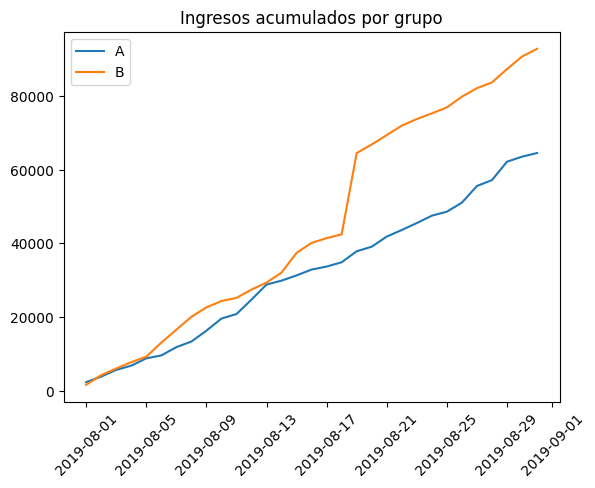

In [22]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.title('Ingresos acumulados por grupo')
plt.xticks(rotation=45)
plt.legend()

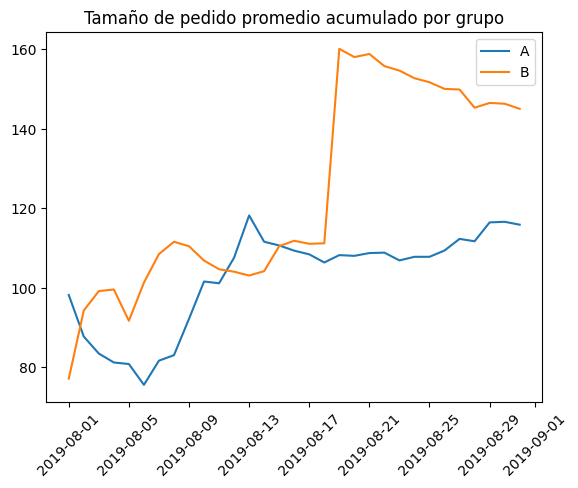

In [23]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label = 'B')
plt.title('Tamaño de pedido promedio acumulado por grupo')
plt.xticks(rotation=45)
plt.legend()

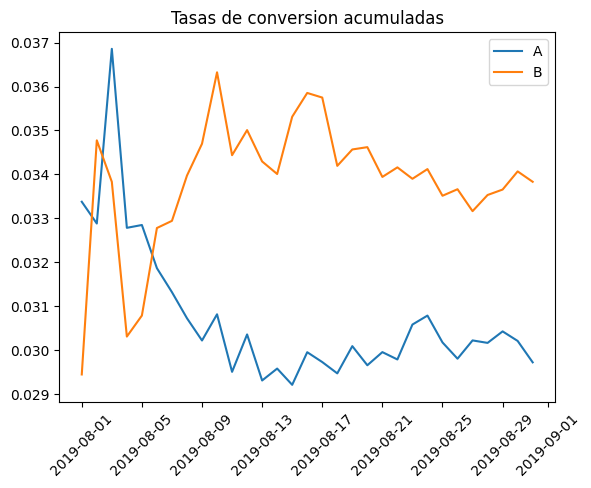

In [24]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['orders']/cumulativeRevenueA['visitors'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['orders']/cumulativeRevenueB['visitors'], label = 'B')
plt.title('Tasas de conversion acumuladas')
plt.xticks(rotation=45)
plt.legend()

In [25]:
ordersByUsers = (
    ordenes.groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']



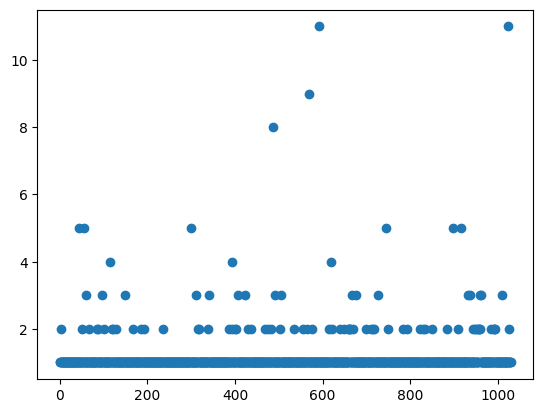

In [26]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])


In [27]:
ordersByUsersA = ordenes[ordenes['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = ordenes[ordenes['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId' : pd.Series.nunique})
ordersByUsersB.columns = ['userId', 'orders']


In [28]:
x_values_A = pd.Series(range(0,len(ordersByUsersA)))
x_values_B = pd.Series(range(0,len(ordersByUsersB)))

No handles with labels found to put in legend.


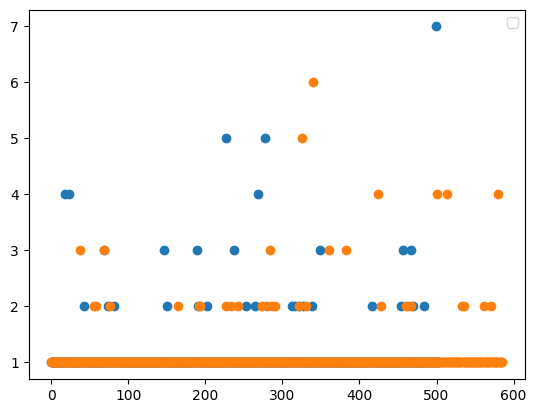

In [29]:
plt.scatter(x_values_A, ordersByUsersA['orders'])
plt.scatter(x_values_B, ordersByUsersB['orders'])
plt.legend()

In [30]:
print('Percentiles 95 99 grupo A', np.percentile(ordersByUsersA['orders'], [95, 99]))
print('Percentiles 95 99 grupo B', np.percentile(ordersByUsersB['orders'], [95, 99]))

Percentiles 95 99 grupo A [2.   3.98]
Percentiles 95 99 grupo B [2.   3.15]


In [31]:
revenueByOrdersA = (
    ordenes[ordenes['group']=='A'].groupby('transactionId', as_index=False)
    .agg({'revenue': 'mean'})
)

revenueByOrdersA.columns = ['orders', 'revenue']

revenueByOrdersB = (
    ordenes[ordenes['group']=='B'].groupby('transactionId', as_index=False)
    .agg({'revenue': 'mean'})
)

revenueByOrdersB.columns = ['orders', 'revenue']

No handles with labels found to put in legend.


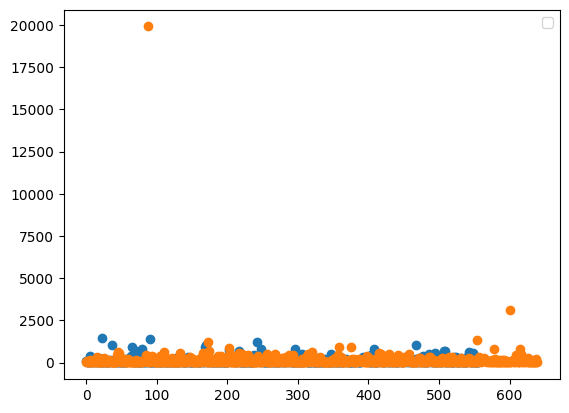

In [32]:
x_v_A = pd.Series(range(0,len(revenueByOrdersA)))
x_v_B = pd.Series(range(0,len(revenueByOrdersB)))

plt.scatter(x_v_A, revenueByOrdersA['revenue'])
plt.scatter(x_v_B, revenueByOrdersB['revenue'])
plt.legend()

In [33]:
print('Percentiles 95 99 del precio de los pedidos grupo A', np.percentile(revenueByOrdersA['revenue'], [90, 95, 99]))
print('Percentiles 95 99 del precio de los pedidos grupo B', np.percentile(revenueByOrdersB['revenue'], [90, 95, 99]))

Percentiles 95 99 del precio de los pedidos grupo A [280.8   413.48  967.796]
Percentiles 95 99 del precio de los pedidos grupo B [285.82  445.825 857.872]


In [34]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(visitas[visitas['group']=='A']['visits'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(visitas[visitas['group']=='B']['visits'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)


In [35]:
from scipy import stats
print("{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

0.017


In [36]:
print("{0:.3f}".format(stats.mannwhitneyu(ordenes[ordenes['group'] == 'A']['revenue'], ordenes[ordenes['group'] == 'B']['revenue'])[1]))

0.692


In [37]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'], ordersByUsersB[ordersByUsersB['orders'] > 2]['userId']], axis = 0)

In [38]:
usersWithExpensiveOrders = ordenes[ordenes['revenue'] > (413.48+445.825)/2]['transactionId']

In [39]:
print(usersWithManyOrders)

18      199603092
23      237748145
68      611059232
146    1230306981
189    1614305549
227    2038680547
237    2108163459
269    2378935119
278    2458001652
349    2988190573
456    3908431265
467    3967698036
499    4256040402
37      249864742
68      457167155
284    2038680547
326    2378935119
340    2458001652
360    2587333274
382    2742574263
424    3062433592
501    3717692402
514    3803269165
580    4256040402
Name: userId, dtype: int64


## Pruebas de hipotesis

In [40]:
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()

In [41]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))]['orders'], pd.Series(0, index=np.arange(visitas[visitas['group'] == 'A']['visits'].sum() - len(ordersByUsersA['orders'])), name = 'orders')], axis = 0)

In [42]:
sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))]['orders'], pd.Series(0, index=np.arange(visitas[visitas['group'] == 'B']['visits'].sum() - len(ordersByUsersB['orders'])), name = 'orders')], axis = 0)

In [43]:
print("{0:.3f}".format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))

0.012


In [44]:
print("{0:.3f}".format(stats.mannwhitneyu(
    ordenes[np.logical_and(
        ordenes['group']=='A',  # Selecciona datos en el grupo A
        np.logical_not(ordenes['visitorId'].isin(abnormalUsers)))]['revenue'],  # Excluye los usuarios anormales y selecciona los datos de ingreso para el grupo A
    ordenes[np.logical_and(
        ordenes['group']=='B',  # Selecciona datos en el grupo B
        np.logical_not(ordenes['visitorId'].isin(abnormalUsers)))]['revenue']  # Excluye los usuarios anormales y selecciona los datos de ingreso para el grupo B
)[1]))  # Extrae el valor p de los resultados de la prueba

# Muestra la diferencia relativa en el ingreso medio entre los grupos B y A
print("{0:.3f}".format(
    ordenes[np.logical_and(ordenes['group']=='B',  # Selecciona datos en el grupo B
           np.logical_not(ordenes['visitorId'].isin(abnormalUsers)))]['revenue'].mean() /  # Calcula el ingreso medio para el grupo B
    ordenes[np.logical_and(ordenes['group']=='A',  # Selecciona datos en el grupo A
           np.logical_not(ordenes['visitorId'].isin(abnormalUsers)))]['revenue'].mean() - 1))  

0.706
0.228


## Resuldado de analisis del test A/B

El grupo B de la prueba A/B presento un mayor ingreso acumulado que el grupo A, esta diferencia se incremento con forme avanzo el tiempo, el grupo B también presento un mayor tamaño de pedido promedio acumulado durante la mayor parte de la prueba. El grupo A inicialmente obtuvo una mayor tasa de conversión acumulada, sin embargo, transcurridos 5 días después del inicio de la prueba, el grupo A y B presentaron una misma tasa de conversión acumulada, después de ese momento, el grupo B presento una mayor tasa de conversión durante el resto de la prueba. El 95% de los visitantes hicieron 2 o menos compras tanto en el grupo A y B, mientras que el 95% de los visitantes hicieron pedidos que caen por debajo de los 285.82 dólares en el grupo B y 280.8 en el grupo A. La prueba de hipótesis antes y después de filtrar los datos anómalos indican una diferencia significativa en la tasa de conversión entre el grupo A y grupo B, por otro lado no hay una diferencia significativa en el tamaño del pedido entre el grupo A y grupo B

# Conclusiones finales

Las hipotesis 0, 7, 8 y 2 mostraron los mejores RICE y ICE, si bien la hipotesis 7 mostro el mayor RICE, esto se debe porque afecta a todos los usuarios, sin embargo, esto no es necesariamente positivo para la conversion, recomiendo enfocarse en las otras tres hipotesis. Por otro lado, el analisis de las pruebas A/B demostro que el grupo B presento mayores tasas de conversion y un mayor ingreso acumulado que el grupo A, sin embargo, los compradores de ambos grupos realizaron pedidos del mismo tamaño y el mismo numero de pedidos, por lo que la diferencia de ingresos generados por el grupo B se debe a la mayor tasa de retencion que presenta. Se aconseja adoptar la estrategia B ya que fue claramente 

<div class="alert alert-block alert-success">
<b>Comentario general (1ra Iteracion)</b> <a class=“tocSkip”></a>

Hiciste un buen trabajo con las visualizaciones, los cálculos y  los ejercicios propuestos los has resuelto muy bien planteando conclusiones claras sobre los resultados obtenidos en cada paso.
    
Planteaste muy buenas conclusiones en base a tus datos que es un punto importante que deben tener tus proyectos, como Data Analyst debes buscar apoyar en la toma de decisiones basadas en datos.
    
Saludos!
</div>